Working with Neural Network Models

© Hans Nieminen, Satakunta University of Applied Sciences

# Exercise 6.1

The function:

$f(x,y,z) = (\frac{1}{3}x - 3y^3+2z)z^2=\frac{1}{3}xz^2-3y^3z^2+2z^3$

Partial derivatives are the following:

$$
\frac{\partial f}{\partial x}=\frac{1}{3}z^2
$$$$
\frac{\partial f}{\partial y}=-3z^2\times 3y^2=-9y^2z^2
$$$$
\frac{\partial f}{\partial z}=\frac{1}{3}x\times 2z - 3y^3\times 2z  + 2\times 3z^2= \frac{2}{3}xz-6y^3z+6z^2
$$

So the gradient is the following

$$
\nabla f(x,y,z)=(\frac{1}{3}z^2,-9y^2z^2,\frac{2}{3}xz-6y^3z+6z^2)
$$


# Exercise 6.2

In [ ]:
import numpy as np

In [ ]:
def f(x,y,z):
  return 2*x**2-0.5*x+0.3*y**3-z**3+2*z+2.5

In [ ]:
def grad_f(x,y,z):
  df_dx = 4*x-0.5
  df_dy = 0.9*y**2
  df_dz = -3*z**2+2
  return np.array([df_dx, df_dy, df_dz])

In [ ]:
initial_point = np.array([0.0, 0.0, 0.0])
learning_rate = 0.01
num_iterations = 500

In [ ]:
def gradient_descent(gradient_func, initial_point, learning_rate, num_iterations,
                     display=False, display_step=10):
  current_point = initial_point
  for i in range(num_iterations):
    grad = gradient_func(*current_point)
    current_point -= learning_rate * grad
    if display and (i+1)%display_step==0:
      print(f'iteration {i+1}: point={current_point}')
  return current_point

In [ ]:
min_point = gradient_descent(grad_f,
                             initial_point,
                             learning_rate,
                             num_iterations,
                             display=True,
                             display_step=50)
min_value = f(*min_point)

iteration 50: point=[ 0.10876428  0.         -0.69033629]
iteration 100: point=[ 0.12289121  0.         -0.80543559]
iteration 150: point=[ 0.1247261   0.         -0.81559313]
iteration 200: point=[ 0.12496442  0.         -0.81642323]
iteration 250: point=[ 0.12499538  0.         -0.81649063]
iteration 300: point=[ 0.1249994  0.        -0.8164961]
iteration 350: point=[ 0.12499992  0.         -0.81649654]
iteration 400: point=[ 0.12499999  0.         -0.81649658]
iteration 450: point=[ 0.125       0.         -0.81649658]
iteration 500: point=[ 0.125       0.         -0.81649658]


In [ ]:
print(f'Minimum is {min_value.round(3)} at point {min_point.round(3)}')

Minimum is 1.38 at point [ 0.125  0.    -0.816]


# Exercise 6.3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
class ANN(object):
    def __init__(self, sizes, hidden_act = "none", output_act = "none",
                 learning_rate = 0.1, random_state = None):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.
        For example, if the list was [2, 3, 1] then it would be a
        three-layer network, with the first layer containing 2 neurons,
        the second layer 3 neurons, and the third layer 1 neuron.
        The biases and weights for the network are initialized randomly,
        using a Gaussian distribution with mean 0, and variance 1.
        Note that the first layer is assumed to be an input layer.
        Parameter ``hidden_act`` contains the activation function name used
        in hidden layers.
        Parameter ``output_act`` contains the activation function name used
        in output layer.
        Parameter ``loss_func`` must be either MSE or LogLoss."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.input_size = sizes[0]
        self.output_size = sizes[-1]

        # biases and weights together
        self.W = []
        rng = np.random.RandomState(random_state)
        for i in np.arange(0, self.num_layers - 2):
            # initialize weight matrix (the + 1 is for the bias)
            w = rng.randn(self.sizes[i] + 1, self.sizes[i + 1] + 1)
            self.W.append(w / np.sqrt(self.sizes[i]))
        # last layer is different: it doesn't need a bias
        w = rng.randn(self.sizes[-2] + 1, self.sizes[-1])
        self.W.append(w / np.sqrt(self.sizes[-2]))

        # set activation functions for hidden layers
        if hidden_act.lower() == "sigmoid":
            self.hidden_act = self.sigmoid
            self.hidden_prime = self.sigmoid_prime
        elif hidden_act.lower() == "tanh":
            self.hidden_act = self.tanh
            self.hidden_prime = self.tanh_prime
        elif hidden_act.lower() == "relu":
            self.hidden_act = self.ReLU
            self.hidden_prime = self.ReLU_prime
        elif hidden_act.lower() == "none":
            self.hidden_act = self.no_activation
            self.hidden_prime = self.no_activation_prime
        else:
            raise ValueError('Parameter hidden_act has to be one of these: "sigmoid", "tanh", "ReLU", "none".')

        # set activation function for output layer
        if output_act.lower() == 'none':
            self.output_act = self.no_activation
            self.output_prime = self.no_activation_prime
        elif output_act.lower() == "sigmoid":
            self.output_act = self.sigmoid
            self.output_prime = self.sigmoid_prime
        elif output_act.lower() == "softmax":
            self.output_act = self.softmax
            self.output_prime = self.softmax_prime
        else:
           raise ValueError('Parameter output_act has to be one of these: "sigmoid", "softmax", "none".')

        self.alpha = learning_rate
        self.results = pd.DataFrame(columns=["loss", "accuracy"])

    def fit(self, X, y, epochs=100, displayUpdate=1000):
        # insert a column with ones for the bias
        X = np.c_[X, np.ones((X.shape[0]))]
        # loop over the desired number of epochs
        for epoch in np.arange(0, epochs):
            # loop over each data point
            for (x, target) in zip(X,y):
                self.fit_partial(x,target)
            # check if displaying is in order
            if epoch == 0 or (epoch + 1)%displayUpdate == 0:
                loss, acc = self.calculate_loss(X, y, epoch)
                if acc is None:
                    print(f"[Info] epoch={epoch+1}, loss={loss:.7f}")
                else:
                    print(f"[Info] epoch={epoch+1}, loss={loss:.7f}, accuracy={acc:.3f}")

    def fit_partial(self, x, target):
        # activations for each layer
        # np.atleast_2d makes array always 2-dimensional
        activations = [np.atleast_2d(x)]

        # 1. Feedforward
        # loop over the layers
        for layer in np.arange(0, len(self.W)):
            net = activations[layer].dot(self.W[layer])
            # compute the activation
            if layer == len(self.W)-1:
                out = self.output_act(net)
            else:
                out = self.hidden_act(net)
            # add output to list of activations
            activations.append(out)

        # 2. Backpropagation
        # first calculate the output layer
        error = activations[-1] - target
        deltas = [error * self.output_prime(activations[-1])]

        # then the other layer backwards
        for layer in np.arange(len(activations)-2, 0, -1):
            # delta for current layer is equal to the delta of
            # previous layer dotted with the weight matrix
            # of current layer, followed by multiplying the delta
            # by the derivative of the activation function for the
            # current layer
            delta = deltas[-1].dot(self.W[layer].T)
            delta = delta * self.hidden_prime(activations[layer])
            deltas.append(delta)

        # 3. Update weights
        # since we looped over layers in reverse order we reverse the deltas
        deltas = deltas[::-1]

        for layer in np.arange(0, len(self.W)):
            # update weights by taking the dot product of the layer
            # activations with theris respective deltas, then multiplying
            # this value by learning rate (some small number)
            self.W[layer] += -self.alpha * activations[layer].T.dot(deltas[layer])

    def calculate_loss(self, X, targets, epoch):
        targets = np.atleast_2d(targets)
        # make the predictions
        predictions = self.predict(X, addBias=False)
        # then compute the loss (- loss function here is either 0.5*MSE or cross-entropy)
        if self.output_act == self.softmax:  # = classification -> cross-entropy
            loss = -np.sum(targets * np.log(predictions + 1e-15)) / len(targets)
        else:
            loss = 0.5 * np.sum((predictions - targets) ** 2)

        if self.output_act == self.no_activation:  # = regression -> no accuracy
            acc = None
            new_row = pd.DataFrame({"epoch": [epoch+1], "loss": [loss]})
        else:
            acc = (predictions.argmax(axis=1) == targets.argmax(axis=1)).mean()
            new_row = pd.DataFrame({"epoch": [epoch+1], "loss": [loss], "accuracy": [acc]})
        self.results = pd.concat([self.results, new_row], ignore_index=True)
        return (loss, acc)

    def predict(self, X, addBias = True):
        p = np.atleast_2d(X)

        if addBias:
            p = np.c_[p, np.ones((p.shape[0]))]

        # loop over layers
        for layer in np.arange(0, len(self.W)):
            if layer == len(self.W)-1:
                p = self.output_act(np.dot(p, self.W[layer]))
            else:
                p = self.hidden_act(np.dot(p, self.W[layer]))

        return p

    # Activation functions
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def ReLU(self, x):
        return (x > 0) * x

    def no_activation(self, x):
        return x

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def sigmoid_prime(self, x):
       # return self.sigmoid(x)*(1-self.sigmoid(x))
        return x*(1-x)

    def tanh_prime(self, x):
        return 1-np.tanh(x)**2

    def ReLU_prime(self, x):
        return x > 0

    def softmax_prime(self, x):
        # Derivative of softmax: https://deepnotes.io/softmax-crossentropy
        # Here we use the same as sigmoid_prime
        return x * (1 - x)

    def no_activation_prime(self, x):
        return 1

In [ ]:
random_state = 127

In [ ]:
wine = load_wine()
X = wine.data
y = wine.target

In [ ]:
X.shape

In [ ]:
y_ohe = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

In [ ]:
y_ohe[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_ohe,
                                                    test_size=0.2,
                                                    random_state=random_state)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
ann = ANN(sizes=[13, 7, 5, 3],
          hidden_act="tanh",
          output_act="softmax",
          learning_rate=0.1,
          random_state=random_state)

In [ ]:
ann.fit(X_train, y_train, epochs=100, displayUpdate=20)

<ipython-input-9-ffbbe9441d2d>:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat([self.results, new_row], ignore_index=True)


[Info] epoch=1, loss=0.4085198, accuracy=0.901
[Info] epoch=20, loss=0.0275933, accuracy=1.000
[Info] epoch=40, loss=0.0179121, accuracy=1.000
[Info] epoch=60, loss=0.0140955, accuracy=1.000
[Info] epoch=80, loss=0.0119384, accuracy=1.000
[Info] epoch=100, loss=0.0105140, accuracy=1.000


In [ ]:
outputs = ann.predict(X_test)

In [ ]:
outputs

array([[1.38665848e-02, 9.84471768e-01, 1.66164706e-03],
       [2.53834084e-03, 6.17865862e-03, 9.91283001e-01],
       [1.19005114e-03, 9.96499256e-01, 2.31069315e-03],
       [1.65999919e-03, 5.84203567e-02, 9.39919644e-01],
       [2.70774060e-03, 5.19218714e-03, 9.92100072e-01],
       [9.92390397e-01, 5.42661203e-03, 2.18299055e-03],
       [2.23205545e-03, 9.96487949e-01, 1.27999589e-03],
       [6.45055527e-03, 4.01702895e-03, 9.89532416e-01],
       [9.93801566e-01, 7.92560893e-04, 5.40587266e-03],
       [9.94864853e-01, 1.66553238e-03, 3.46961434e-03],
       [9.94239804e-01, 1.62329300e-03, 4.13690308e-03],
       [9.95017966e-01, 1.34423201e-03, 3.63780238e-03],
       [3.96751936e-04, 9.93061540e-01, 6.54170840e-03],
       [2.86739350e-03, 9.96040280e-01, 1.09232619e-03],
       [9.87567108e-01, 4.50733558e-04, 1.19821585e-02],
       [1.16685335e-02, 9.85609720e-01, 2.72174616e-03],
       [9.89565001e-01, 8.75078455e-03, 1.68421456e-03],
       [1.24013561e-03, 9.96764

In [ ]:
print("[INFO] evaluating network...")
predictions = outputs.argmax(axis=1)
test_accuracy = round(accuracy_score(y_test.argmax(axis=1), predictions),3)
print('Test accuracy')
print(test_accuracy)
print('Test confusion matrix')
print(confusion_matrix(y_test.argmax(axis=1), predictions))

[INFO] evaluating network...
Test accuracy
0.972
Test confusion matrix
[[16  0  0]
 [ 0 13  1]
 [ 0  0  6]]


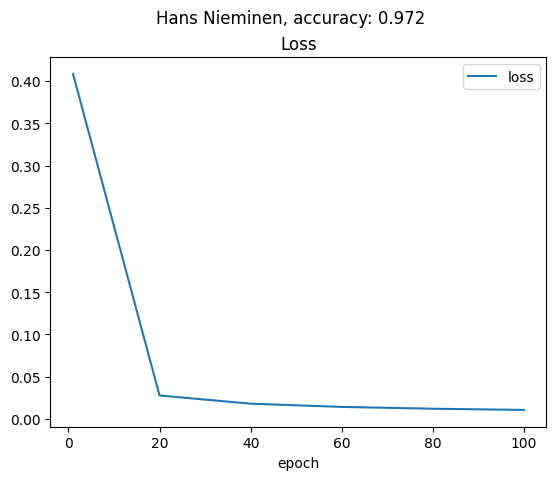

In [ ]:
name = 'Hans Nieminen'
ann.results.plot(x= 'epoch', y = "loss", title='Loss')
plt.suptitle(f'{name}, accuracy: {test_accuracy}')
plt.show()

# Exercise 6.4

In [ ]:
import numpy as np

In [ ]:
steps = 3
gamma = 0.1
W_steps = []
W = np.array([[0.3, 0.1],
              [0.1, 0.2]])
epsilon = 10**-8
S = 0

In [ ]:
for t in range(1, steps+1):
  # compute partial derivatives
  delta_w = 2 * W
  S += np.square(delta_w)
  alpha = gamma / (np.sqrt(S+epsilon))
  W = W - alpha * delta_w
  W_steps.append((t,W))

In [ ]:
W_steps

[(1,
  array([[2.00000001e-01, 1.24999977e-08],
         [1.24999977e-08, 1.00000003e-01]])),
 (2,
  array([[1.44529982e-01, 1.56249952e-15],
         [1.56249952e-15, 5.52786436e-02]])),
 (3,
  array([[1.07322586e-01, 1.95312415e-22],
         [1.95312415e-22, 3.12797498e-02]]))]

In [ ]:
W

array([[1.07322586e-01, 1.95312415e-22],
       [1.95312415e-22, 3.12797498e-02]])

In [ ]:
print(W.sum().round(3))

0.139
